# YIELD CURVE: Forecasting a Recession

A deeper dive into [U.S. Department of the Treasury](https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield) Yield Curve data and it's predictive capaiblities. 

In an efficiently performing market, long-term bonds have higher bond yield rates than shorter-term bonds, T-notes, and T-bills as the market expects greater risk in investing in long-term bonds (a lot can happen in 30 years). However, when the yield curve inverts, the bond yield rates for shorter-term bonds are higher than long-term bond yield rates. An Inverted Yield Curve is used as one predictor of a recession as it captures the nervousness of investors about the near term market outlook.

In my analysis below, an Inverted Yield Curve occurs when the ratio of long-term bond rates (i.e. 30 years, 10 years) versus short-term bonds(6 months, 1 year, 10 years) is between 0 and 1. The yield curve last inverted between 2006 and 2007. 

In [37]:
%matplotlib inline
import requests
import xml.etree.ElementTree as et
from xml.parsers.expat import ExpatError
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import urllib.request as urllib2

## Retrieving and Organizing the Data

The following code demonstrates scraping the Treasury website and organizing the data into a Pandas dataframe.

In [38]:
#---- Scrape XML From Treasury Website ----#
year  = 2018
curpath = os.path.dirname(os.path.realpath("./yield"))
data_dir = data_dir = curpath + '/data/xml'
while (year <=2018):
    filename = os.path.join(data_dir, '%s.xml' %year )
    resp = urllib2.urlopen('http://data.treasury.gov/feed.svc/DailyTreasuryYieldCurveRateData?$filter=year(NEW_DATE)%20eq%20'+ str(year))
    xml = resp.read()
    with open(filename, "wb") as file:
        file.write(xml)
        print("Pulled file: %s" % filename)    
    year += 1

Pulled file: /opt/yield/data/xml/2018.xml


In [39]:
#-------- Retrieve XML Files --------#
# Current  directory:
curpath = os.path.dirname( os.path.abspath("./yield/"))

# Traverse a directory
data_dir = curpath + '/data/'
def traverse_directory(directory):
    files = [directory+f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return files

In [40]:
# ----Prepend Namespaces for Retrieval ----#
def prepend_atom(s):
    return '{http://www.w3.org/2005/Atom}' + s

def prepend_schema(s):
    return '{http://schemas.microsoft.com/ado/2007/08/dataservices/metadata}%s' % s

def prepend_ds(s):
    return '{http://schemas.microsoft.com/ado/2007/08/dataservices}%s' % s

In [41]:
# ----Build a Dictionary of All Entries from 1990 to Present  ----#
def build_entries_dict(count, dentries, root):
    for elem in root.findall(prepend_atom('entry')):
        count +=1
        dentry = {}
        properties = elem.find(prepend_atom('content')).find(prepend_schema('properties'))
        iid = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('Id')).text
        date = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('NEW_DATE')).text
        bc_1month = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_1MONTH')).text
        bc_3month = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_3MONTH')).text
        bc_6month = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_6MONTH')).text
        bc_1yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_1YEAR')).text
        bc_2yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_2YEAR')).text
        bc_3yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_3YEAR')).text
        bc_5yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_5YEAR')).text
        bc_7yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_7YEAR')).text
        bc_10yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_10YEAR')).text
        bc_30yr = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_30YEAR')).text
        bc_30yr_display = elem.find(prepend_atom('content')).find(prepend_schema('properties')).find(prepend_ds('BC_30YEARDISPLAY')).text
        dentry['date'] = date
        dentry['1m'] = bc_1month
        dentry['3m'] = bc_3month
        dentry['6m'] = bc_6month
        dentry['1y'] = bc_1yr
        dentry['2y'] = bc_2yr
        dentry['3y'] = bc_3yr
        dentry['5y'] = bc_5yr
        dentry['7y'] = bc_7yr
        dentry['10y'] = bc_10yr
        dentry['30y'] = bc_30yr
        dentries[iid] = dentry
    return dentries

In [42]:
# ---- Parse the XML to create a Dict of All Data ---#
def parse_xml(filename, count, dentries):
    try:
        #Parse the given XML file:
        tree = et.parse(filename)
    except ExpatError as e:
        print ("[XML] Error (line %d): %d" % (e.lineno, e.code))
        print ("[XML] Offset: %d" % (e.offset))
        raise e
    except IOError as e:
        print ("[XML] I/O Error %d: %s" % (e.errno, e.strerror))
        raise e
    else:
        root = tree.getroot()
        dentries = build_entries_dict(count, dentries, root)
    return dentries

In [43]:
#-------- Main --------#
count = 0
dentries = {}
curpath = os.path.dirname( os.path.abspath("./yield/"))
data_dir = curpath + '/data/xml/'
xml_files = traverse_directory(data_dir)
for f in xml_files:
    dentries = parse_xml(f, count, dentries)


In [44]:
# ---- Load JSON Into Pandas DataFrame ----#
# Convert dict to JSON
json_entries = json.dumps(dentries)
# Create a Panda Dataframe
df = pd.read_json(json_entries, convert_dates=True, convert_axes=True, orient='index')
df = df[['date','1m', '3m', '6m', '1y', '2y', '3y', '5y', '7y', '10y', '30y']]
df['30y/10y'] = df['30y']/df['10y']
df['10y/6m'] = df['10y']/df['6m']
df['30y/1y'] = df['30y']/df['1y']
df['30y/6m'] = df ['30y']/df['6m']
df.head()

,date,1m,3m,6m,1y,2y,3y,5y,7y,10y,30y,30y/10y,10y/6m,30y/1y,30y/6m
1644,1990-06-08,NaN,7.96,8.03,8.07,8.33,8.38,8.42,8.51,8.46,8.44,0.997636,1.053549,1.045849,1.051059
1645,1990-06-07,NaN,7.96,8.01,8.07,8.34,8.38,8.41,8.49,8.46,8.43,0.996454,1.056180,1.044610,1.052434
1646,1990-06-11,NaN,7.99,8.07,8.09,8.36,8.41,8.43,8.52,8.48,8.45,0.996462,1.050805,1.044499,1.047088
1647,1990-06-13,NaN,7.93,7.99,8.02,8.27,8.32,8.35,8.44,8.40,8.39,0.998810,1.051314,1.046135,1.050063
1648,1990-06-12,NaN,7.99,8.05,8.09,8.36,8.42,8.44,8.52,8.48,8.45,0.996462,1.053416,1.044499,1.049689


## Visualizing the Data

In [45]:
# ---- Visualize Data ----#
# Global Plot Configs
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (60,22)
plt.rcParams.update({'font.size': 33})

### Bond Yield Rate Ratio For Years 1990 to Present

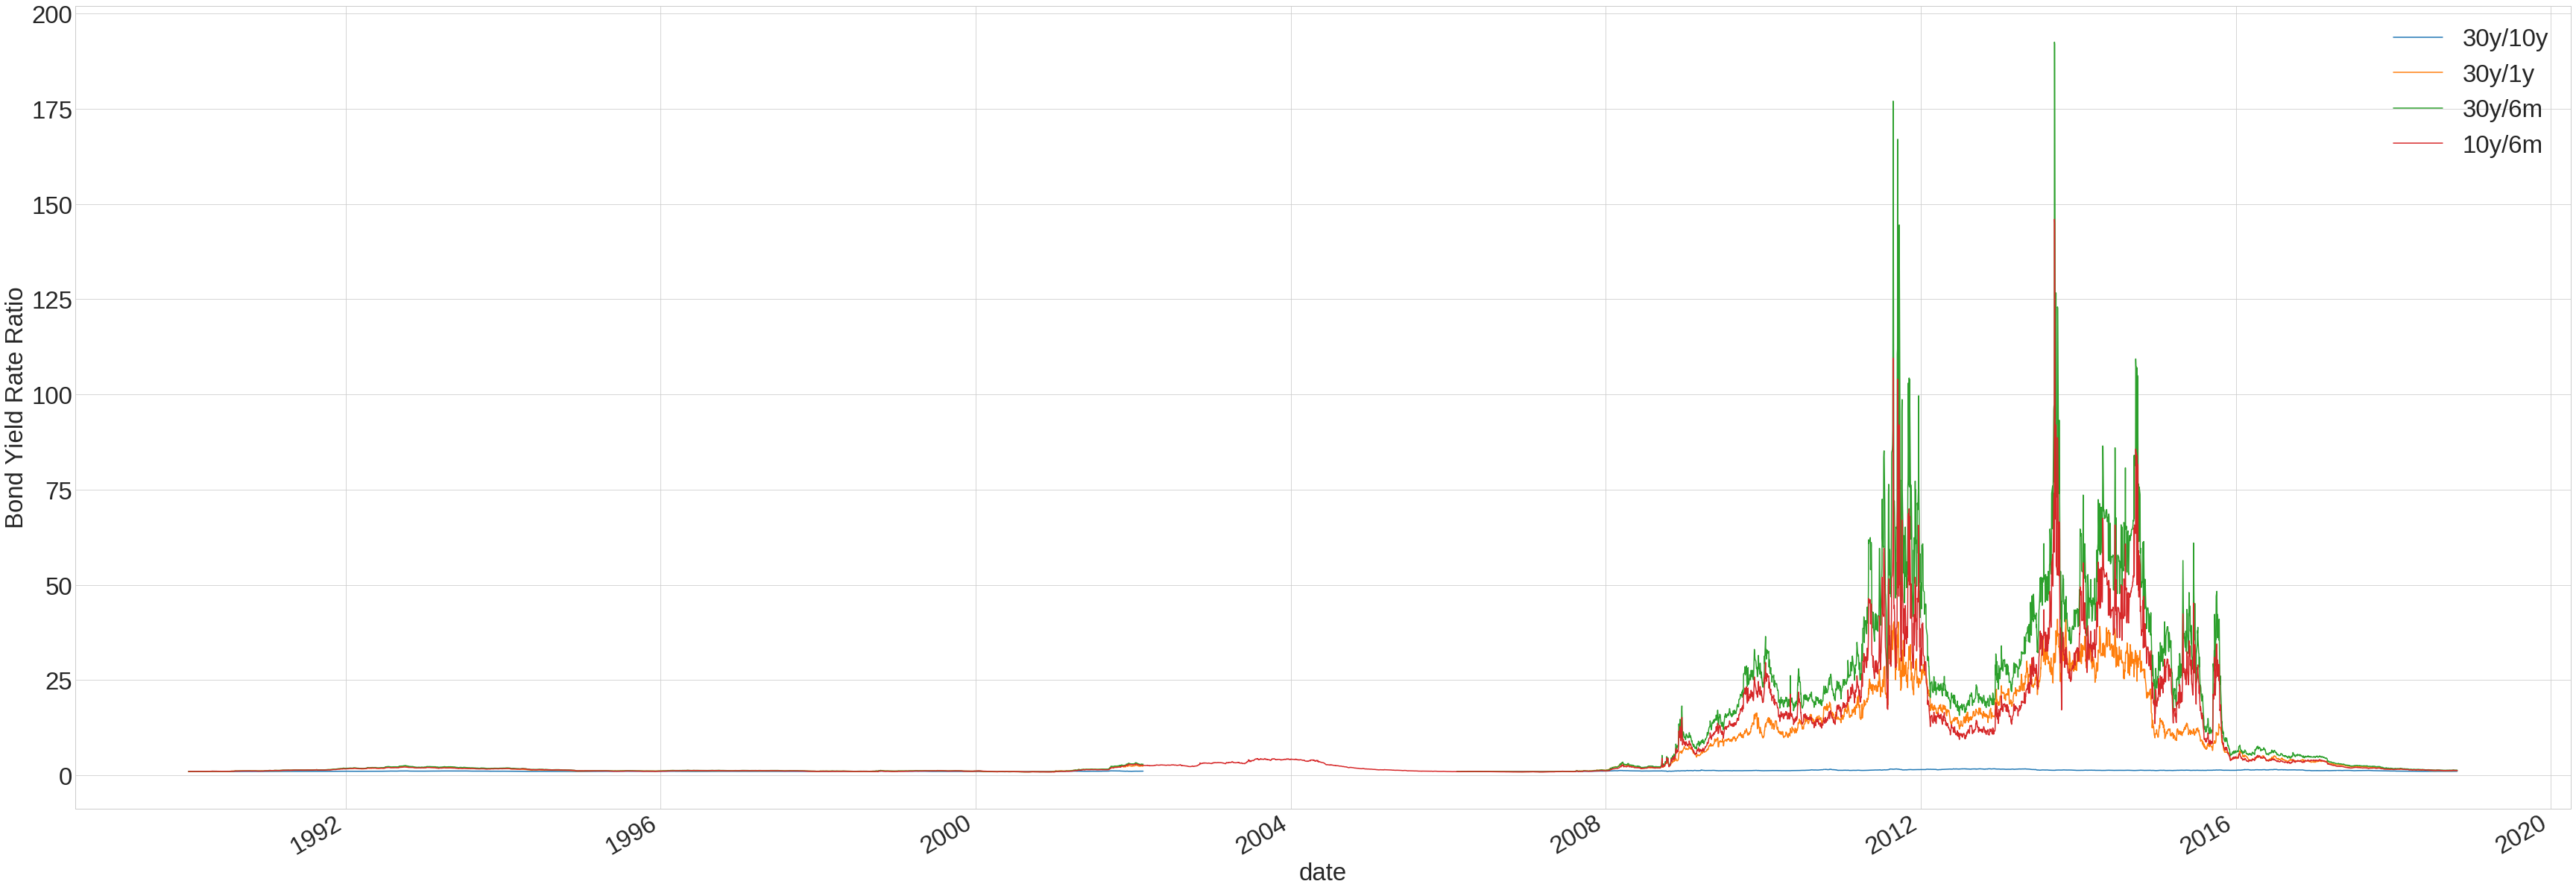

In [46]:
ax = plt.gca()
plt.ylabel('Bond Yield Rate Ratio')
df.plot(kind='line', x='date', y='30y/10y', ax=ax)
df.plot(kind='line', x='date', y='30y/1y', ax=ax)
df.plot(kind='line', x='date', y='30y/6m', ax=ax)
df.plot(kind='line', x='date', y='10y/6m', ax=ax)

plt.show()

### Bond Yield Rate Ratio for Years 2006 to Present

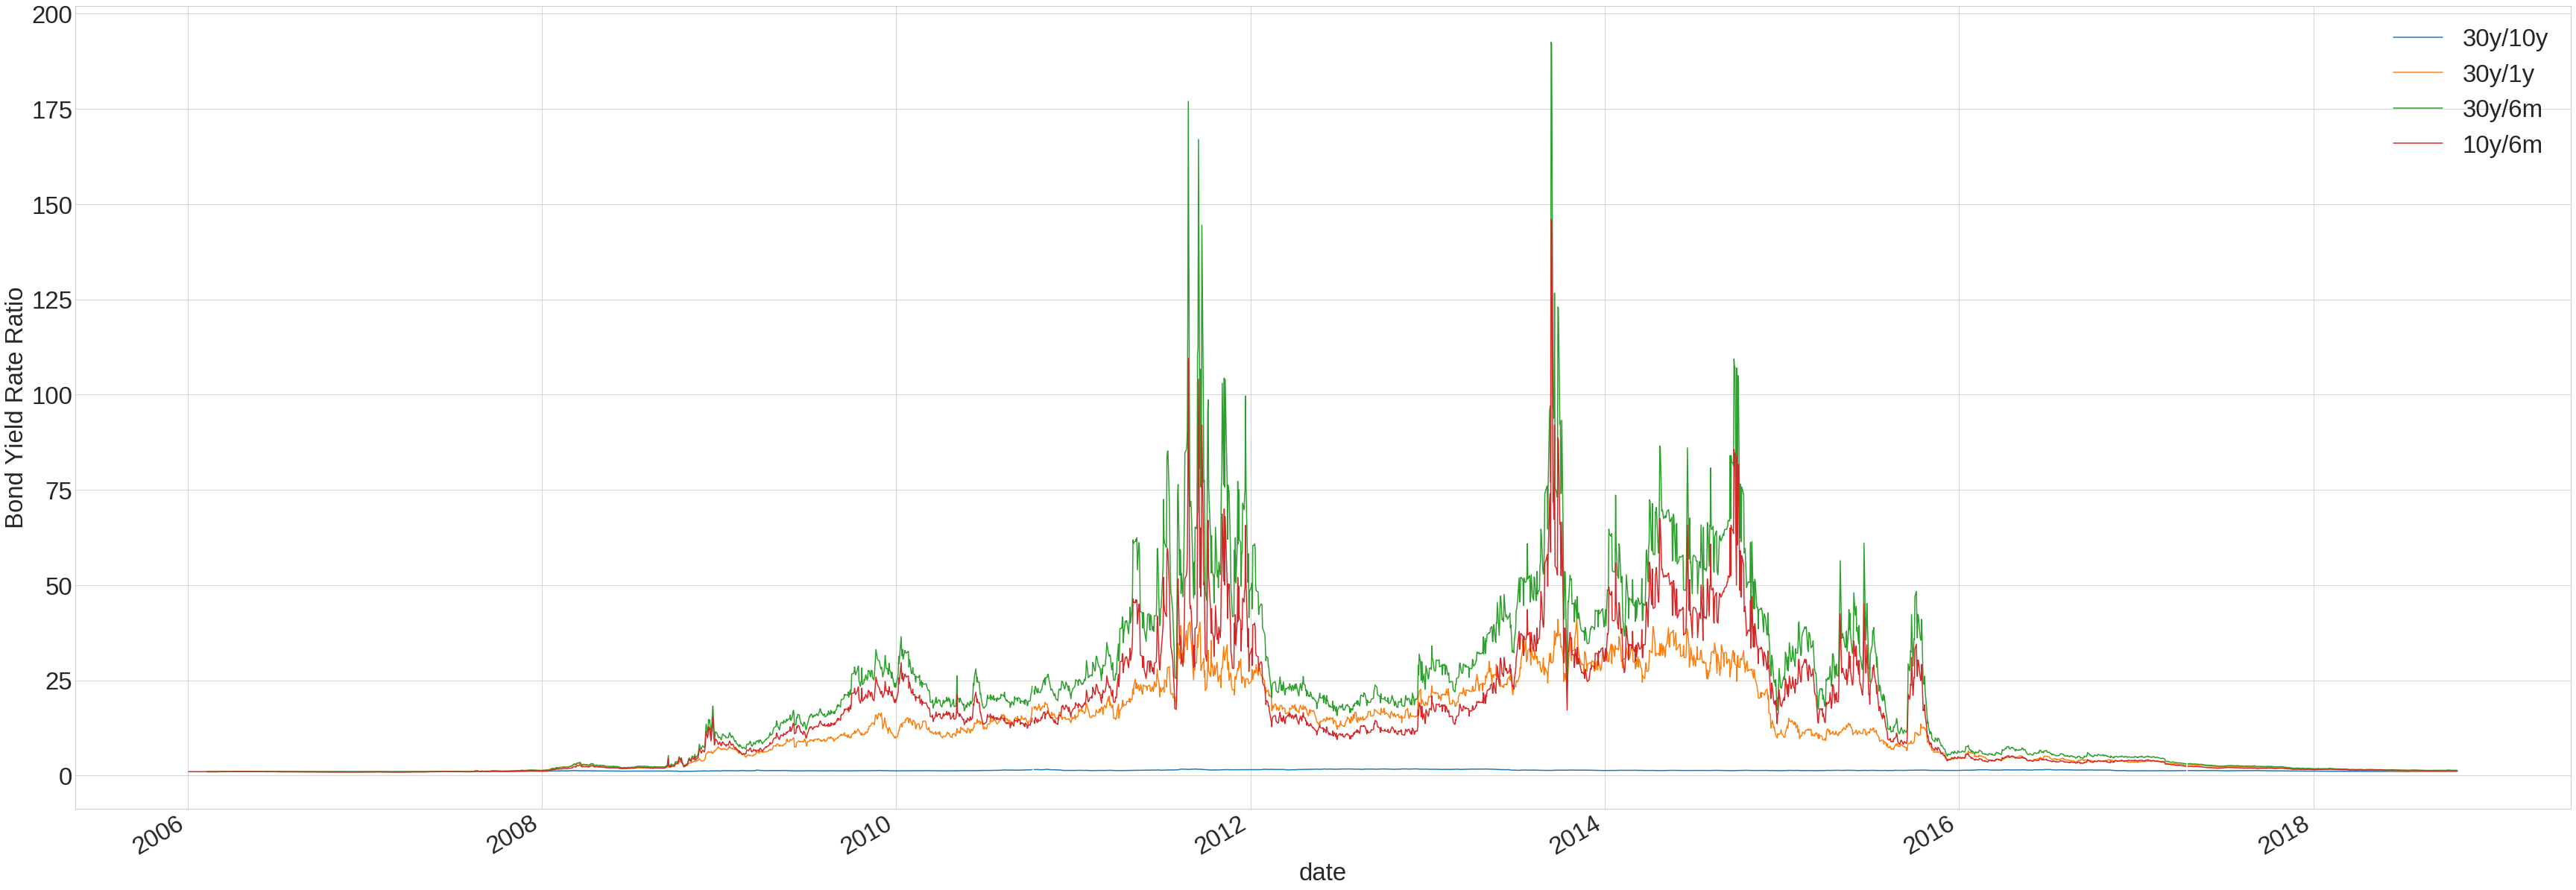

In [47]:
df_lim = df
df_lim = df_lim.loc[df_lim['date']>='2006-01-01']
ax = plt.gca()
plt.ylabel('Bond Yield Rate Ratio')
df_lim.plot(kind='line', x='date', y='30y/10y', ax=ax)
df_lim.plot(kind='line', x='date', y='30y/1y', ax=ax)
df_lim.plot(kind='line', x='date', y='30y/6m', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/6m', ax=ax)

plt.show()

### Bond Yield Rate Ratio for Years 2016 to 2018
 

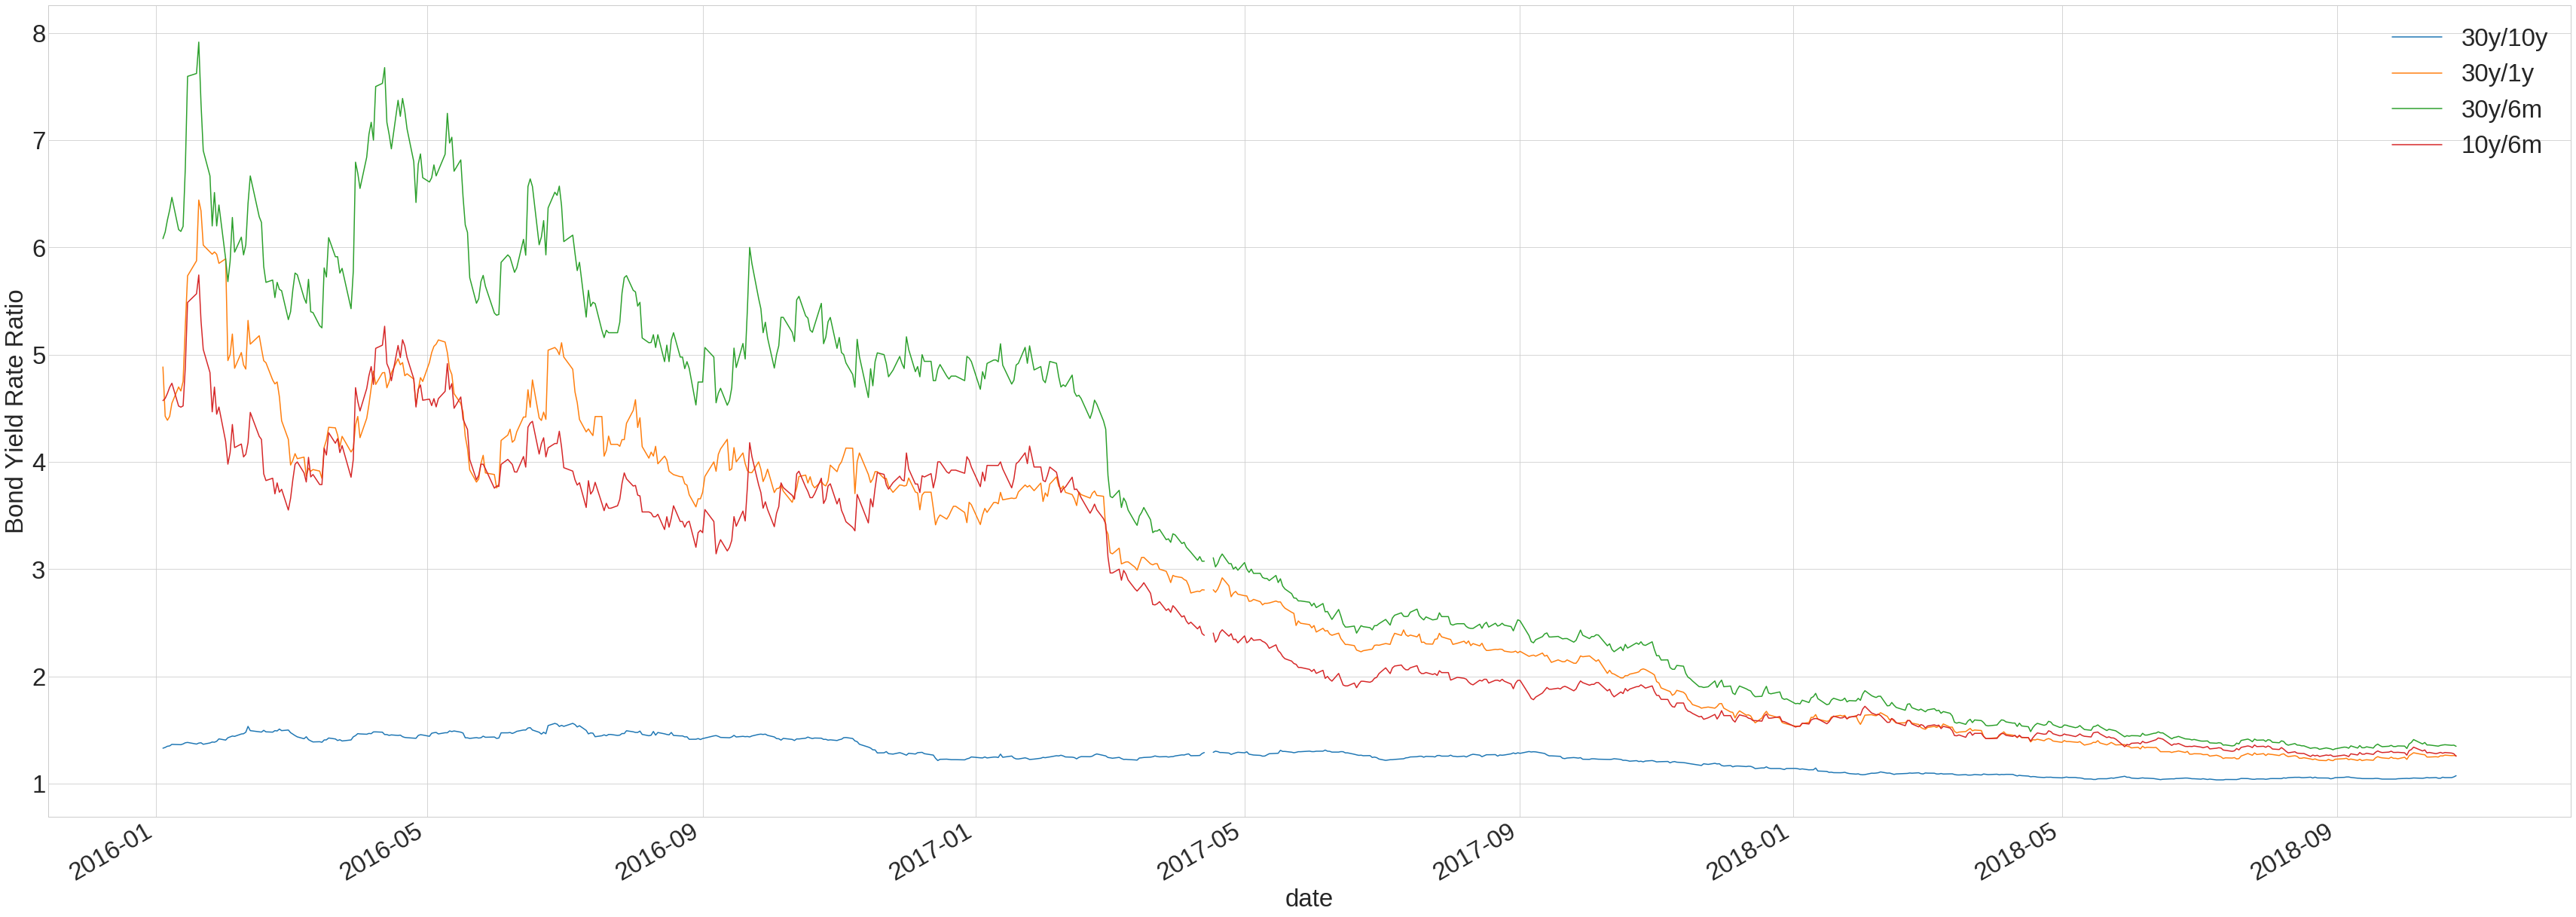

In [48]:
df_lim_16 = df
df_lim_16 = df_lim.loc[df_lim['date']>='2016-01-01']
ax = plt.gca()
plt.ylabel('Bond Yield Rate Ratio')
df_lim_16.plot(kind='line', x='date', y='30y/10y', ax=ax)
df_lim_16.plot(kind='line', x='date', y='30y/1y', ax=ax)
df_lim_16.plot(kind='line', x='date', y='30y/6m', ax=ax)
df_lim_16.plot(kind='line', x='date', y='10y/6m', ax=ax)
plt.show()

### Bond Yield Rate Ratio for Years 2006 to 2007
Interestingly, the yield curve inverted during this period.

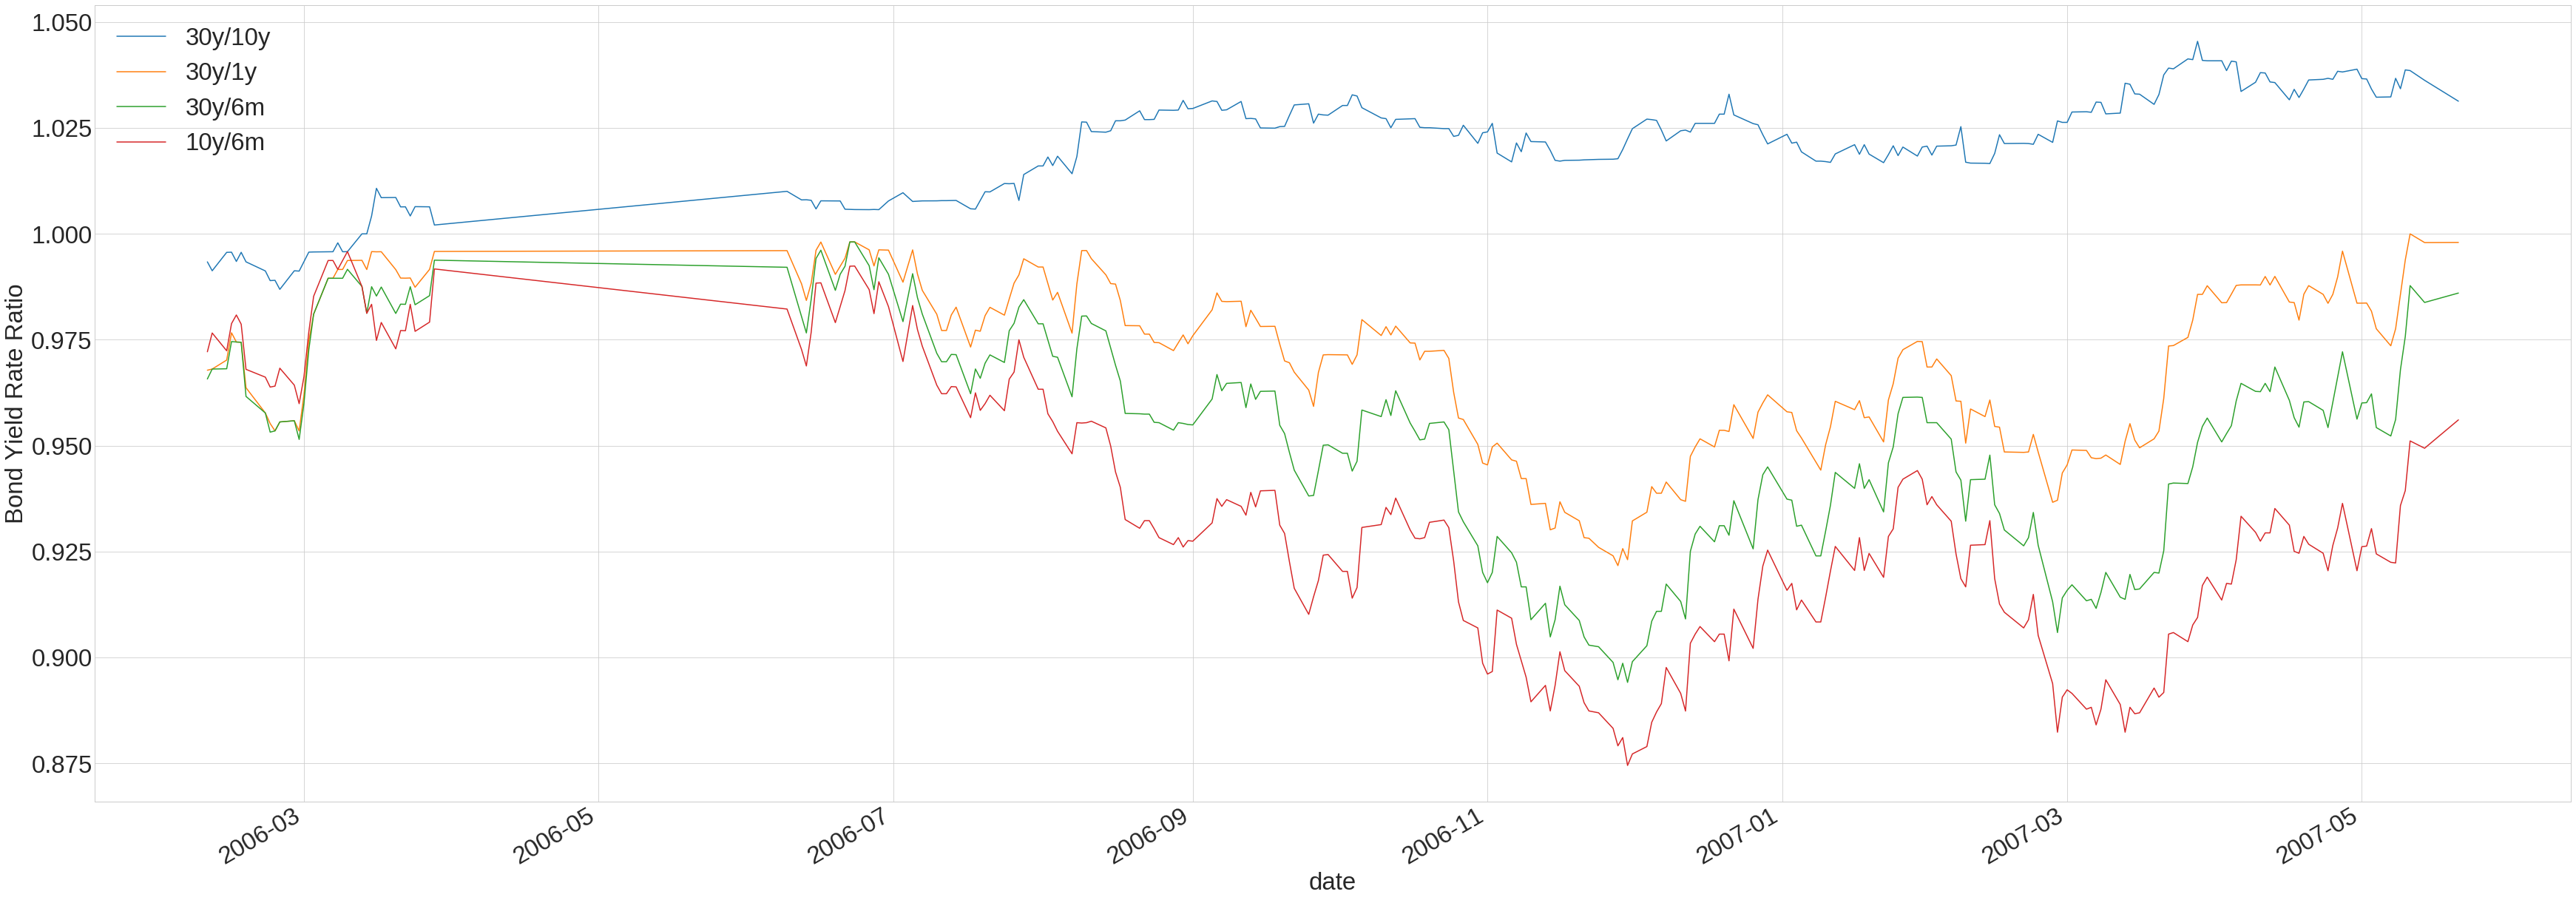

In [49]:
df_lim = df
df_lim = df_lim.loc[(df_lim['date']>='2006-01-01') & (df_lim['30y/1y']<=1) ]
ax = plt.gca()
plt.ylabel('Bond Yield Rate Ratio')
df_lim.plot(kind='line', x='date', y='30y/10y', ax=ax)
df_lim.plot(kind='line', x='date', y='30y/1y', ax=ax)
df_lim.plot(kind='line', x='date', y='30y/6m', ax=ax)
df_lim.plot(kind='line', x='date', y='10y/6m', ax=ax)

plt.show()

### Bond Yield Rate Ratio Comparing 10 Year Bonds to 6 month T-Notes

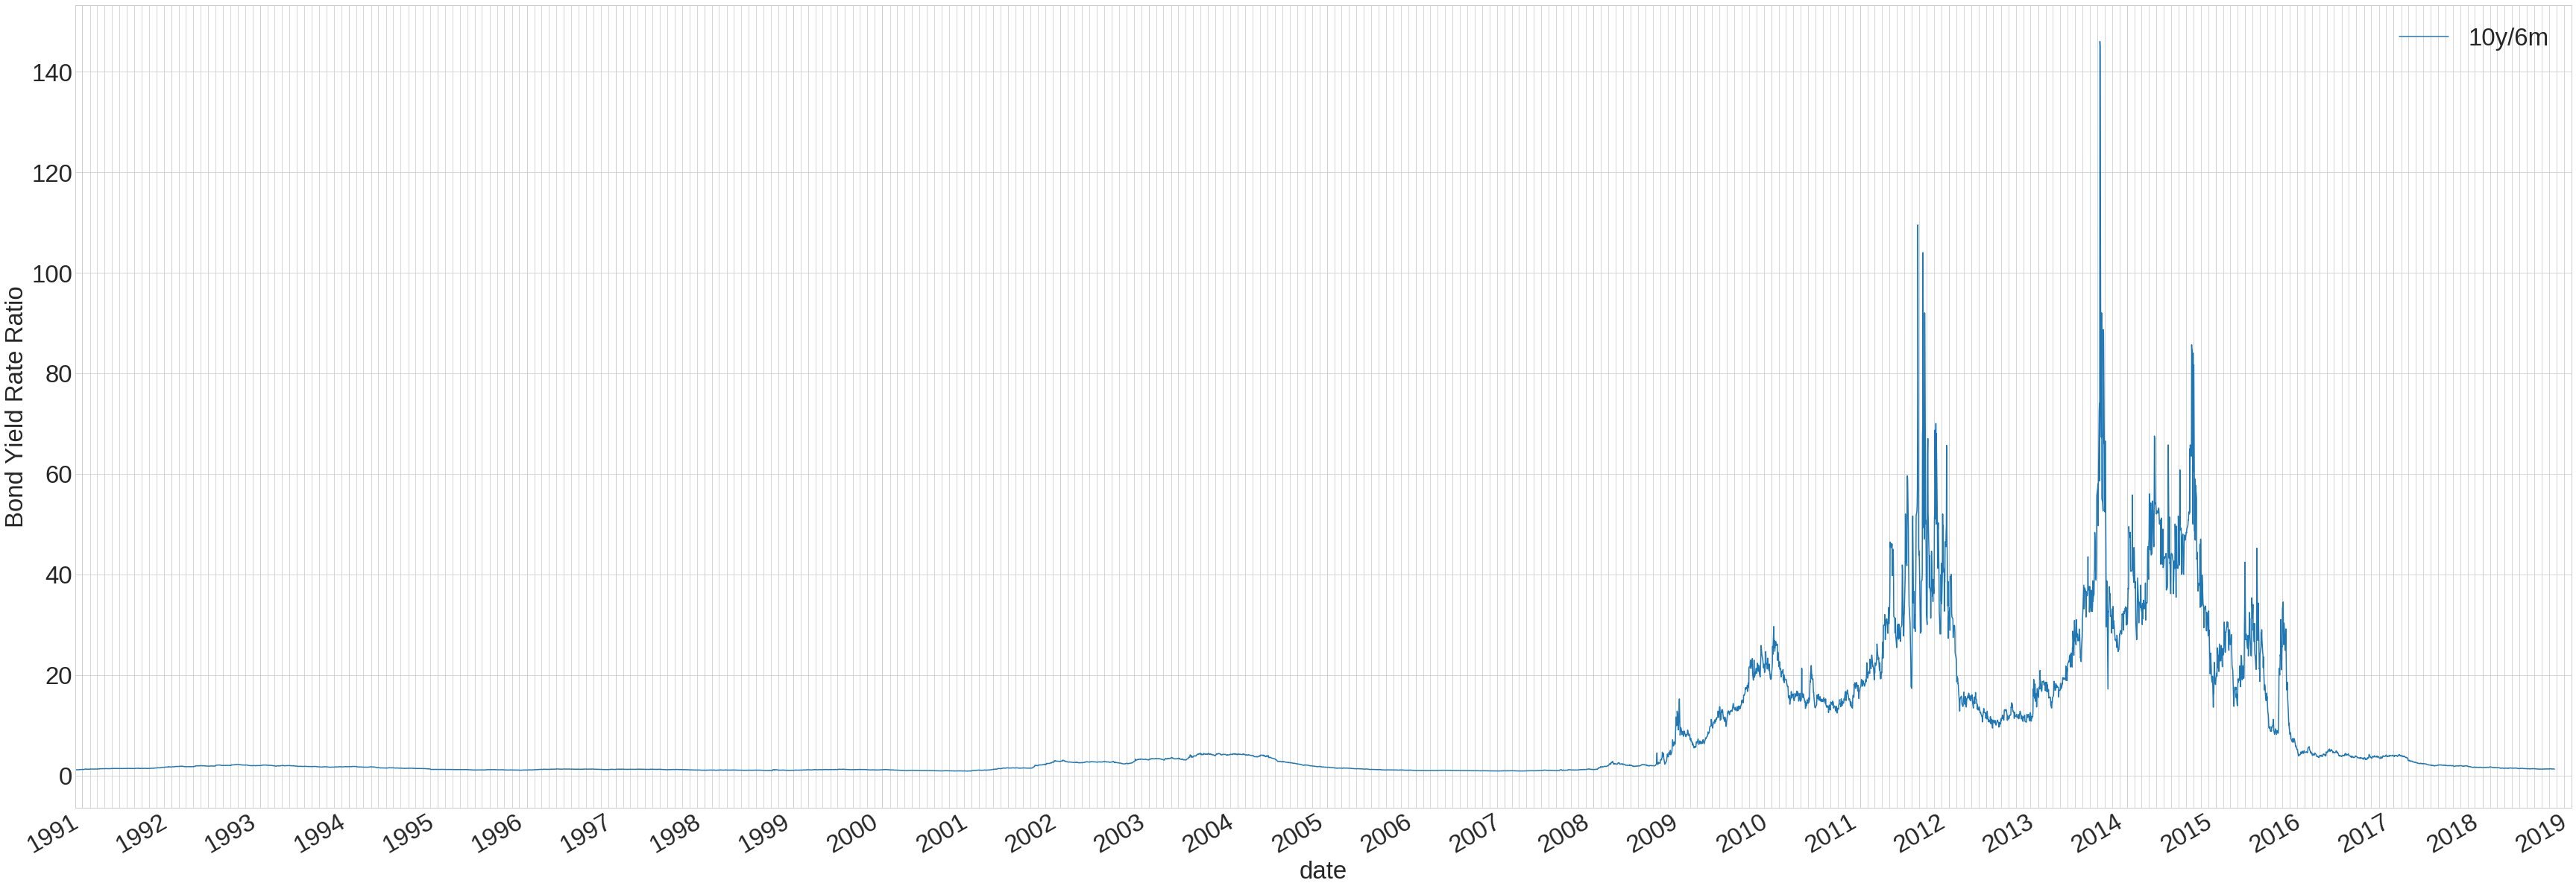

In [50]:
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter('%Y')

ax = plt.subplot()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)
ax.grid(which='both', axis='x')
plt.ylabel('Bond Yield Rate Ratio')
datemin = datetime.date(1990, 12, 2)
datemax = datetime.date(2019 + 0, 1, 1)
ax.set_xlim(datemin, datemax)

df.plot(kind='line', x='date', y='10y/6m', ax=ax)

plt.show()

### Bond Yield Rate Ratios For Years 2016 to 2018

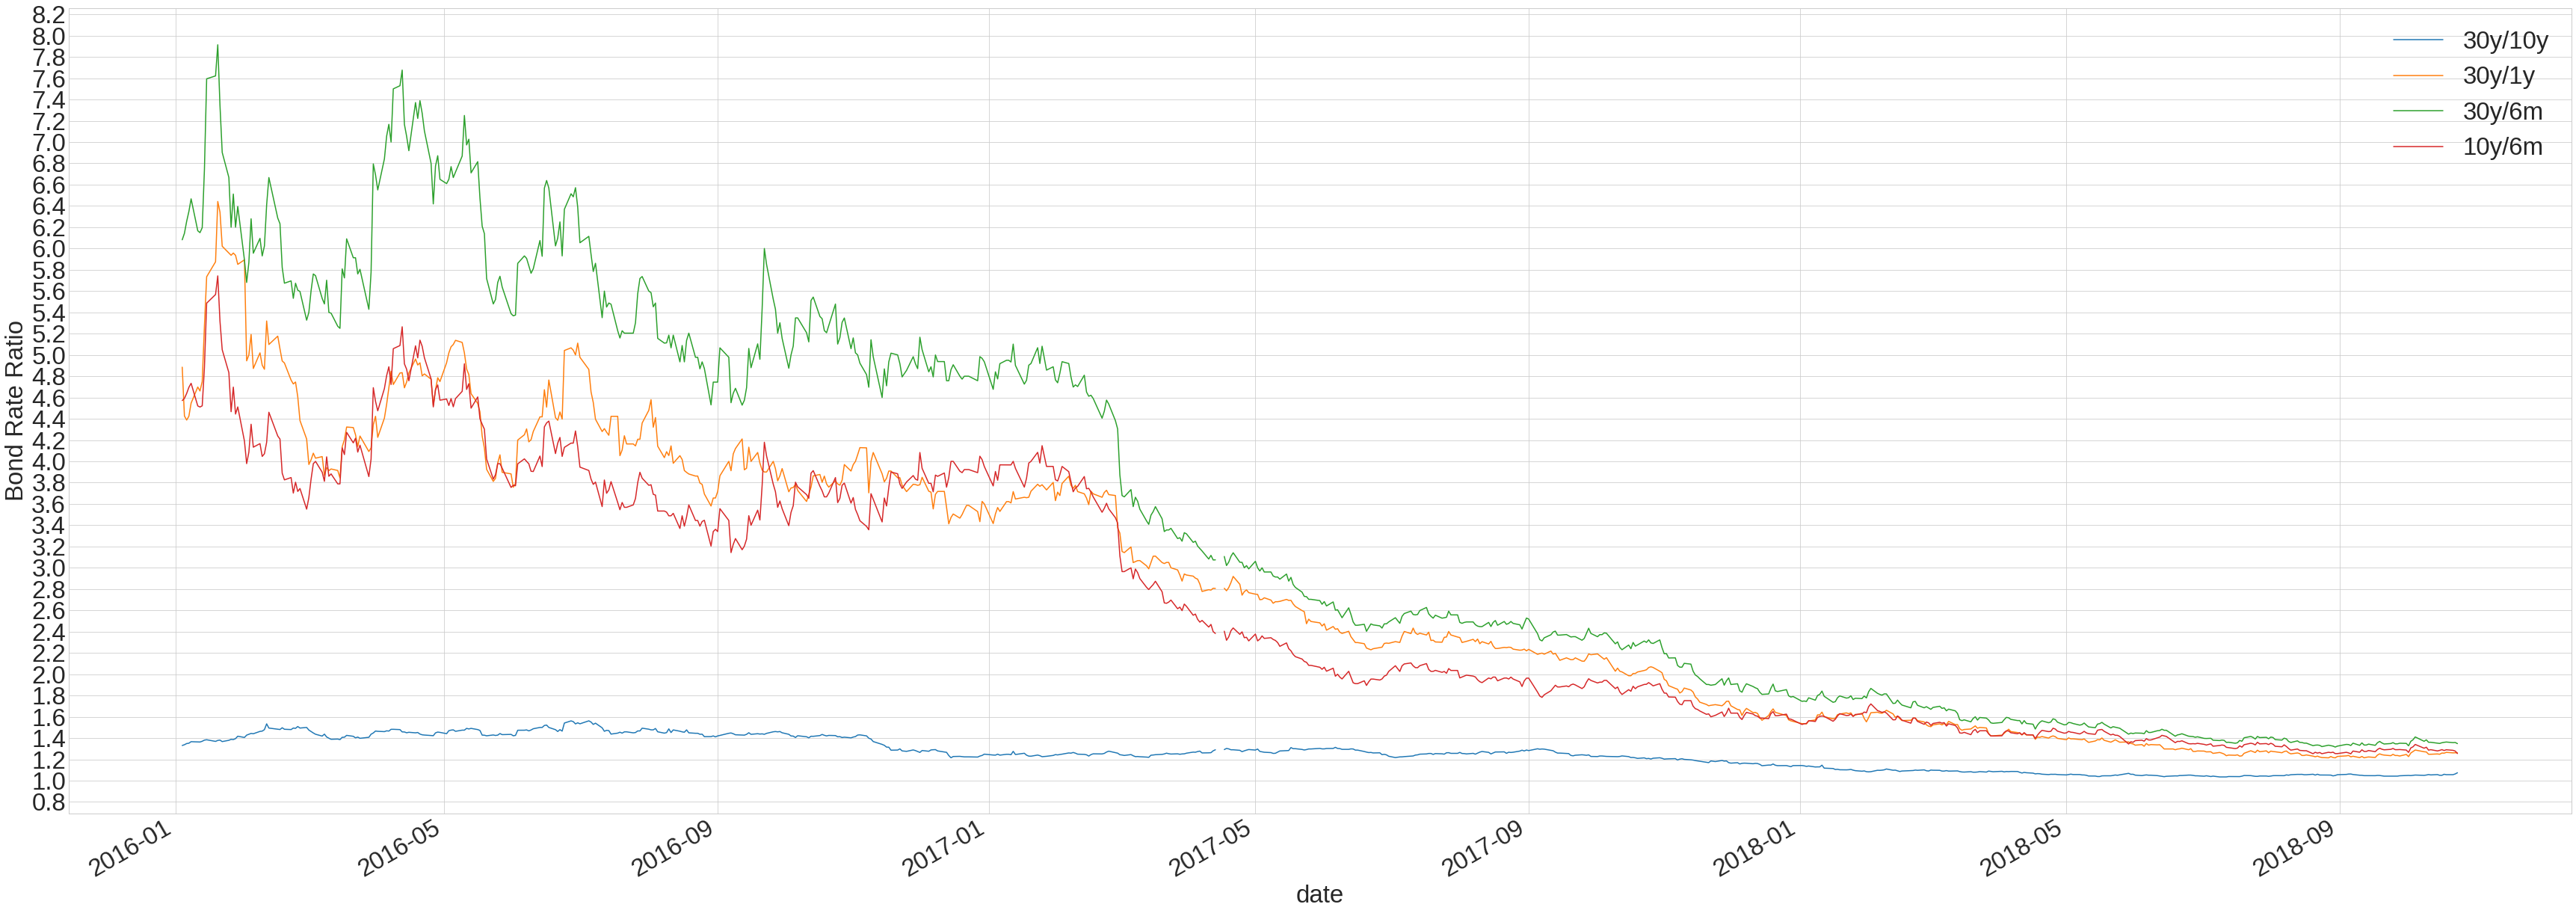

In [51]:
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax = plt.subplot()
plt.ylabel('Bond Rate Ratio')
plt.yticks(np.arange(0, 81, 80))

start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.arange(start, end,.2))
df_lim_16.plot(kind='line', x='date', y='30y/10y', ax=ax)
df_lim_16.plot(kind='line', x='date', y='30y/1y', ax=ax)
df_lim_16.plot(kind='line', x='date', y='30y/6m', ax=ax)
df_lim_16.plot(kind='line', x='date', y='10y/6m', ax=ax)

plt.show()

### Bond Yield Rate Ratios for 2018 to Present

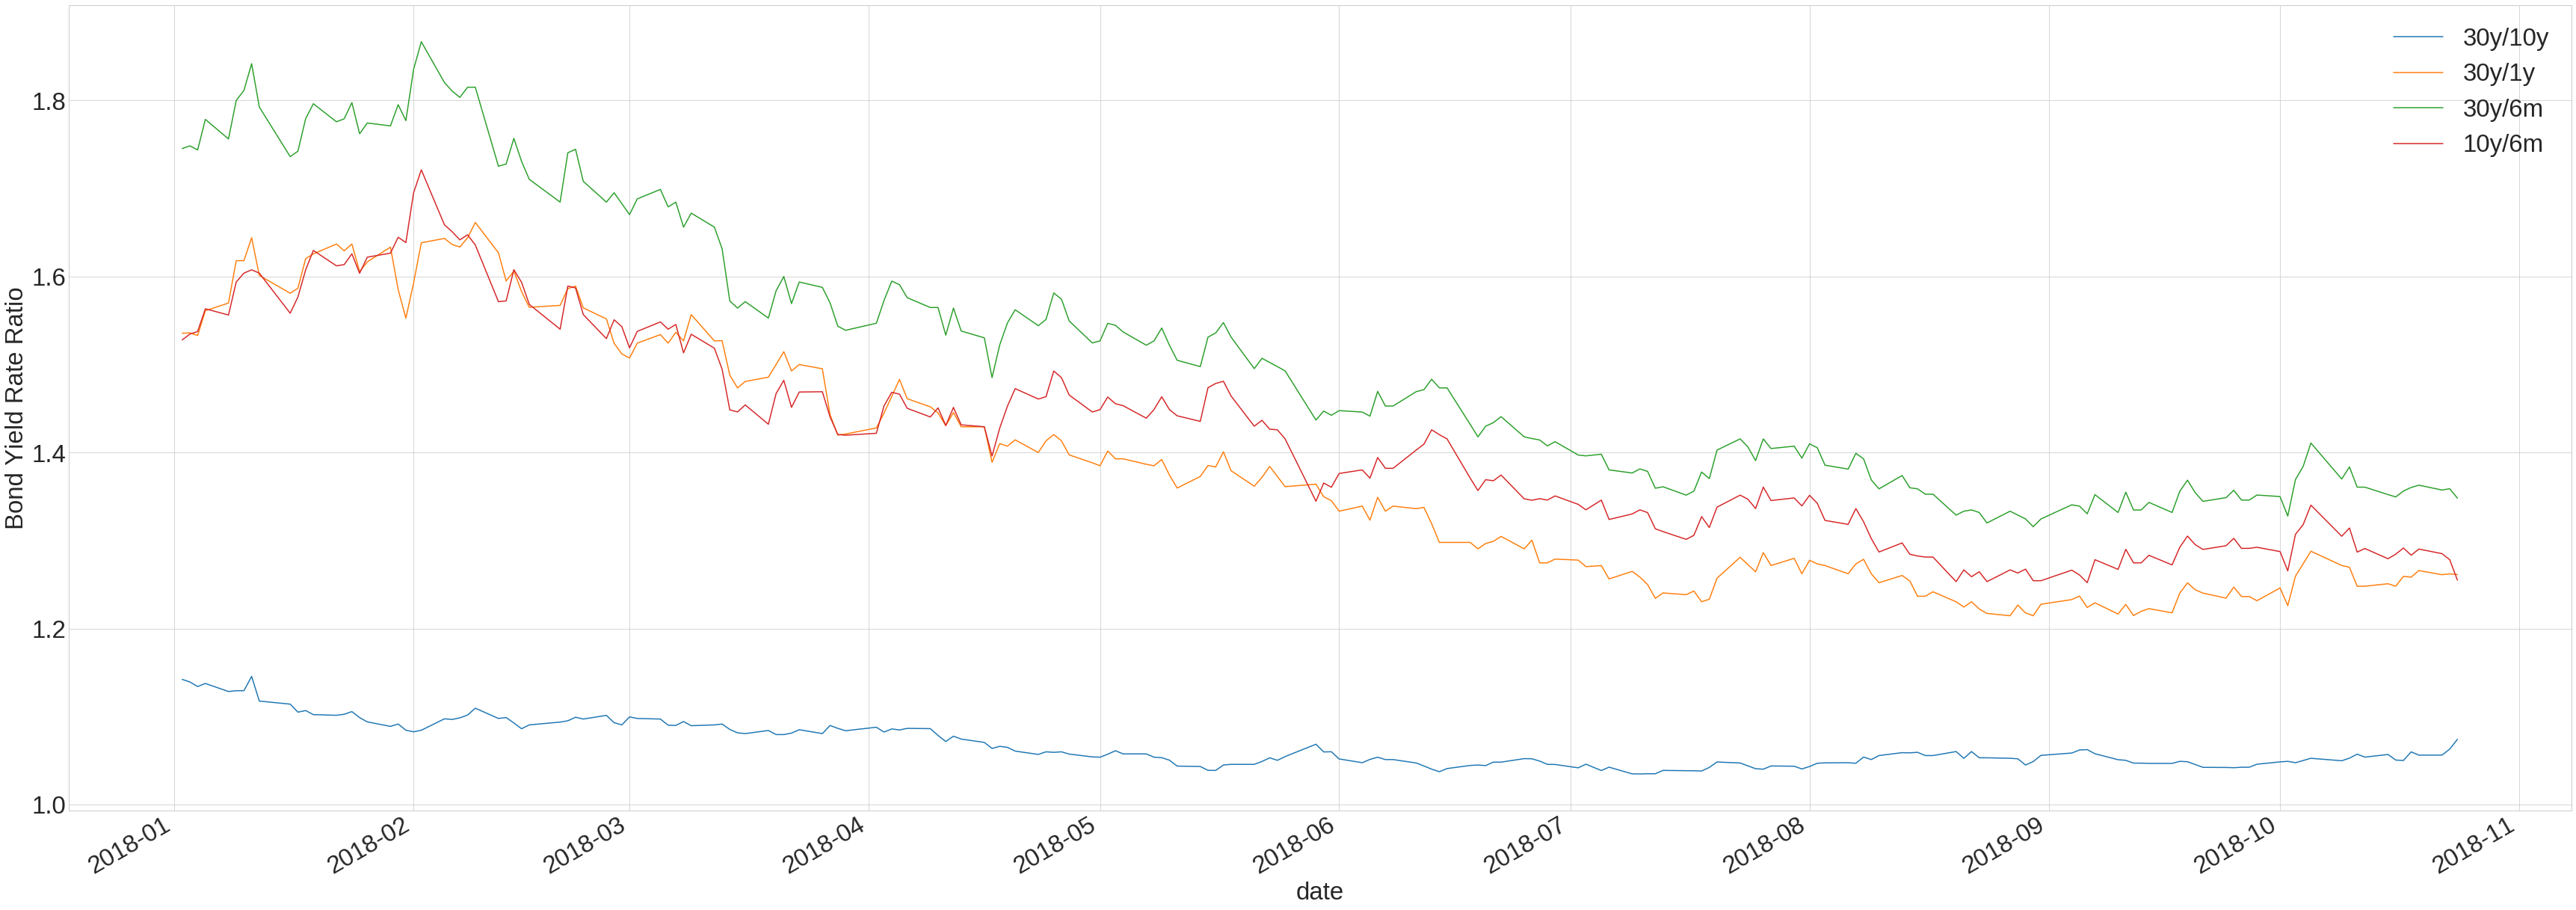

In [52]:
df_lim_18 = df
df_lim_18 = df.loc[df['date']>='2018-01-01']
ax = plt.gca()
plt.ylabel('Bond Yield Rate Ratio')
df_lim_18.plot(kind='line', x='date', y='30y/10y', ax=ax)
df_lim_18.plot(kind='line', x='date', y='30y/1y', ax=ax)
df_lim_18.plot(kind='line', x='date', y='30y/6m', ax=ax)
df_lim_18.plot(kind='line', x='date', y='10y/6m', ax=ax)
plt.show()